## Imports

In [311]:
import csv
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.pyplot import cm

import numpy as np
import trompy as tp
from datetime import datetime
import pandas as pd
import pickle 

%matplotlib inline


from scipy import stats

In [312]:
def extract_event_fn(filename): 
    '''
    function to extract framenumber of events (licks and pump_on) in framenumber
    
    args
    filename - string 
    
    returns 
    licks_fn - lits of integers
        framenumber of licks
    pump_on_fn - list of integers 
        framenumber when pump turns on
    
    '''
    df= pd.read_csv(filename)
    
    #Extracts pump on framenumber
    pump_fn = list(df[df['Item1'] == 'pump_on']['Item2.Item2'])
    
    
    #Extracts licks framenumber
    licks_fn = list (df[df['Item1']== 'Lick']['Item2.Item2'])

      
    return pump_fn, licks_fn
        


In [313]:
def get_hit_miss_trial (pump_fn, licks_fn): 
    '''
    function to get hit and miss trials
    
    arg 
    pump_fn - list of integers
        framenumber for when the pump turns on 
    licks_fn - list of integers
        framenumber for all licks
    triallenght - int float (optional, default set to 100 frames (10sec))
    
    returns 
    hit_trial - list of int 
        pump on frame number in hit trials (lick > 0)
    miss_trial - list of int 
        pump on frame number in missed trials (lick = 0)
    
    '''
    hit_trial=[]
    miss_trial=[]
    for p in pump_fn: 
        temp=[]
        for lick in licks_fn: 
            if lick > p and lick < p + 100: 
                temp.append(lick)
            
        if len(temp)> 0:
            hit_trial.append(p)
        if len(temp) == 0: 
            miss_trial.append(p)
    return hit_trial, miss_trial

In [314]:
def get_licks_trial (pump_fn, licks_fn, triallength=100):
    '''
    function to get licks within one trial 
    licks aligned to pump on (pump_fn)
    
    arg 
    pump_fn - list of integers
        framenumber for when the pump turns on 
    licks_fn - list of integers
        framenumber for all licks
    triallenght - int float (optional, default set to 100 frames (10sec))
    
    returns 
    licks_trial - list of list of integers
        list of all licks in all trials aligned to pump on (in frames)
    licks_all_trial - list of integers
        number of licks of each trial 
    licks_hit_trial - list of integers 
        number of licks per trial for hit trials 
    latency - list of integers
        latency to first lick after pump on (in frames)
        
    
    '''

    # All licks aligned to pump on 
    licks_trial=[]
    for p in pump_fn:
        temp=[]
        for lick in licks_fn: 
            if lick > p and lick < p + 100:
                temp.append(lick - p)
        licks_trial.append(temp)
        
        
    #licks per trial (all and hit trials) aligned to pump on 
    licks_all_trial=[]
    licks_hit_trial=[]
    for trial in licks_trial: 
        licks_all_trial.append(len(trial))
        if len(trial) > 0: 
            licks_hit_trial.append(len(trial))
            
            
    #Latency to first lick after pump on
    temp_latency=[]
    latency_all_temp=[]
    for trial in licks_trial:
        latency_all_temp.append(trial[:1])
        if len(trial) > 0: 
            temp_latency.append(trial[:1])
        
            
    
    latency=[trial for sublist in temp_latency for trial in sublist] #List comprehension to convert list of lists to flat list     
    
        
    return licks_trial, licks_all_trial, licks_hit_trial, latency, latency_all_temp

In [315]:
def get_binned_latency(latency_all): 
    '''
    function to get mean latency for binned trials  
    bins = 10 trials 
    
    args
    latency_all - list of lists of int
        list all the latencies to first lick in each trial. if no lick list is empty 
        
    returns 
    latency1/2/3/4 - float 
        the mean latency for hit trials in 4 different bins (10 trial per bin)
    '''
    bin1=tp.flatten_list(latency_all[:10])
    bin2=tp.flatten_list(latency_all[10:20])
    bin3=tp.flatten_list(latency_all[20:30])
    bin4=tp.flatten_list(latency_all[30:])

    latency1=np.mean(bin1)
    latency2=np.mean(bin2)
    latency3=np.mean(bin3)
    latency4=np.mean(bin4)
    
    return latency1,latency2,latency3,latency4

In [330]:
def get_binned_hit (data): 
    
    bin1=data[:10]
    bin2=data[10:20]
    bin3=data[20:30]
    bin4=data[30:]


    hit=[]
    miss=[]
    for trial in bin1: 
        if len(trial)>0: 
            hit.append(trial[:1])
        elif len(trial)==0: 
            miss.append(trial)
        
    p_bin1 = (len(hit)/(len(hit)+len(miss)))*100

    hit=[]
    miss=[]
    for trial in bin2: 
        if len(trial)>0: 
            hit.append(trial[:1])
        elif len(trial)==0: 
            miss.append(trial)
    p_bin2 =(len(hit)/(len(hit)+len(miss)))*100

    hit=[]
    miss=[]
    for trial in bin3: 
        if len(trial)>0: 
            hit.append(trial[:1])
        elif len(trial)==0: 
            miss.append(trial)
    p_bin3 =(len(hit)/(len(hit)+len(miss)))*100

    hit=[]
    miss=[]
    for trial in bin4: 
        if len(trial)>0: 
            hit.append(trial[:1])
        elif len(trial)==0: 
            miss.append(trial)
    p_bin4 =(len(hit)/(len(hit)+len(miss)))*100
    
    
    return p_bin1,p_bin2,p_bin3,p_bin4

In [324]:
def make_barscatter(data, ax=None, barlabels=['PR','PRNR','NR','NRPR'], barfacecolor = ['darkcyan','c', 'black', 'grey']):
    
    '''
    function to make barscatter
    
    arg 
    data - list of lists of floats
        The data you want to put into the plot
    barlabels - list of strings
        labels for the bars plotted (optional - defaulte : 'PR','PRNR','NR','NRPR' )
    barfacecolors - list of strings
        colors for the bars (optional- default: ['darkcyan','c', 'black', 'grey'])
    
    
    returns 
    ax - ax to put into sublot
    
    '''
    if ax == None: 
        f,ax = plt.subplots()
        
    tp.barscatter(data, 
#                   paired= True,
                  barfacecolor=barfacecolor,
                  barlabels=barlabels,
                  barlabeloffset=0.04,
                  barfacecolor_option='individual',
                  fontsize = 15,
                  scattersize=110,
                  scatteralpha=0.7,
                  spaced=True,
                  linewidth=1.5,
                  ax=ax)
    
    return ax
    

In [325]:
def get_cumulative_licks(licks_fn): 
    '''
    function to get cumulative licks. 
    lick frame number put into bins and calculated as cumulative
    
    args 
    licks_fn - list of floats 
        the framenumber of all licks in the session 
    bins - float - optional default set to 100 (10 sec)
        size of bins
        
    returns
    lickcum - array of cumulative licks 
    lickbin - array of bins '''
    
    bins=list(range(0,12900,10))
    licks, b = np.histogram(licks_fn, bins=bins)
    lickcum = np.cumsum(licks)
    lickbin = b[1:]
    
    return lickcum, lickbin

In [326]:
def get_grouped_data(dictionary, solution, data ):
    '''
    function to group data and get output from animals grouped into PR, PRNR, NR and NRPR
    
    args
    dictionary - name of dictionaty (eks behav_data)
    solution - string 
        the name of the soltuion, given as a key in the dictionaty (eks 'Ensure')
    data - string
        name of the data/output you want as output (eks 'total licks') 
        
        
        
    '''
    
    PR=[]
    PRNR=[]
    
    NR=[]
    NRPR=[]
    
    for mouse in mice: 
        temp_PR=[]
        temp_PRNR=[]
        
        temp_NR=[]
        temp_NRPR=[]
        
        for key in dictionary.keys():
            d=dictionary[key]
            
            if d['mouse']== mouse and d['solution']==solution and d['diet']== 'PR': 
                temp_PR.append(d[data])
                
            elif d['mouse']==mouse and d['solution']==solution and d['diet']== 'NR':
                temp_NR.append(d[data])
            elif d['mouse']==mouse and d['solution']==solution and d['diet']== 'PRNR':
                temp_PRNR.append(d[data])
            elif d['mouse']==mouse and d['solution']==solution and d['diet']== 'NRPR':
                temp_NRPR.append(d[data])
        if len(temp_PR)> 0:
            PR.append(np.mean(temp_PR))
        if len(temp_NR)>0:
            NR.append(np.mean(temp_NR))
        if len(temp_PRNR)>0:
            PRNR.append(np.mean(temp_PRNR))
        if len(temp_NRPR)>0:
            NRPR.append(np.mean(temp_NRPR))
            
    return PR, PRNR, NR, NRPR
                
        

In [327]:
def grouped_by_session(dictionary, solution,session, output):
    
    
    PR=[]
    PRNR=[]
    
    NR=[]
    NRPR=[]
    
    for key in dictionary.keys():
            d=dictionary[key]
            
            if d['solution']== solution and d['diet'] == 'PR' and d['session'] == session: 
                PR.append(np.mean(d[output]))
            elif d['solution']== solution and d['diet'] == 'PRNR' and d['session'] == session: 
                PRNR.append(np.mean(d[output]))
            elif d['solution']== solution and d['diet'] == 'NR' and d['session'] == session: 
                NR.append(np.mean(d[output]))
            elif d['solution']== solution and d['diet'] == 'NRPR' and d['session'] == session: 
                NRPR.append(np.mean(d[output]))
                
                
    return PR, PRNR, NR, NRPR
        
   

## Metafile reader

In [328]:
rows,header=tp.metafilereader('C:\\Users\\mko102\\UiT Office 365\\O365-Pipette 2 - Dokumenter\\People\\Mette\\GitHub\\2P\\Metafile_VGP2.2.xls',sheetname='Behavior')
# rows_homecage,header=tp.metafilereader('C:\\Users\\mko102\\UiT Office 365\\O365-Pipette 2 - Dokumenter\\People\\Mette\\GitHub\\2P\\Metafile_VGP2.2.xls',sheetname='Homecage')
folder= 'C:\\Users\\mko102\\UiT Office 365\\O365-Pipette 2 - Dokumenter\\People\\Mette\\GitHub\\2P\\VGP2\\Bonsai\\'

File is excel file. Making csv metafile first


## Dictionary

In [331]:
all_data={}

for row in rows: 
    try:
        key=row[0]+ '_' + row[4]
    
        pump_fn, licks_fn = extract_event_fn(folder+row[1])
        hit_trial, miss_trial = get_hit_miss_trial(pump_fn, licks_fn)
        licks_trial, licks_all_trial, licks_hit_trial, latency, latency_all = get_licks_trial(pump_fn, licks_fn)
        cumlicks, bins = get_cumulative_licks(licks_fn)
        latency1, latency2, latency3, latency4 = get_binned_latency(latency_all)
        hit1, hit2, hit3, hit4 = get_binned_hit(latency_all)
        lick_number=[]
        for number, lick in enumerate(licks_fn): 
            lick_number.append(number)
    
        
    
        all_data[key]={}

        all_data[key]['mouse']=row[0]
        all_data[key]['diet']=row[7]
        all_data[key]['solution']=row[8]
        all_data[key]['session']=row[10]
    
        all_data[key]['file']=row[1]
        all_data[key]['licks_fn']= licks_fn
        all_data[key]['number lick']= [number for number in range(1,(len(licks_fn)+1))]
        all_data[key]['lick number']= lick_number
        all_data[key]['pump_fn']= pump_fn
        all_data[key]['licks trial']= licks_trial
        all_data[key]['number of trials']=len(pump_fn)
        all_data[key]['total licks']=len(licks_fn)
        all_data[key]['hit trial'] = len(hit_trial)
        all_data[key]['miss trials']= len(miss_trial)
        all_data[key]['licks per trial']= np.mean(licks_all_trial)
        all_data[key]['licks hit trial']= np.mean(licks_hit_trial)
        all_data[key]['latency']= np.mean(latency)
        all_data[key]['latency all']=latency_all
        all_data[key]['latency1']=latency1
        all_data[key]['latency2']=latency2
        all_data[key]['latency3']=latency3
        all_data[key]['latency4']=latency4
        
        
        
        all_data[key]['cumulative licks']=cumlicks
        all_data[key]['lick bins']=bins
        
    
    except FileNotFoundError: 
        print('Cannot find file for', key)

ZeroDivisionError: division by zero

In [208]:

with open('..//output//behavdata.pickle', 'wb') as file:
    pickle.dump(all_data, file, protocol=pickle.HIGHEST_PROTOCOL)

with open('..//output//behavdata.pickle', 'rb') as file:
    b = pickle.load(file)

50.0

In [209]:
mice=[]

for key in all_data.keys(): 
    d=all_data[key]
    mouseid=d['mouse']
    if mouseid not in mice: mice.append(mouseid)


for m in mice: 
    if m == 'VGP305':
        mice.remove(m)


## Total number of licks

In [210]:
ensure_PR,ensure_PRNR,ensure_NR,ensure_NRPR= get_grouped_data(all_data, 'Ensure', 'total licks')
cas_PR,cas_PRNR,cas_NR,cas_NRPR= get_grouped_data(all_data, 'Cas', 'total licks')
malt_PR,malt_PRNR,malt_NR,malt_NRPR= get_grouped_data(all_data, 'Malt.', 'total licks')

Ensure

In [211]:
print('PR',ensure_PR)
print('PRNR', ensure_PRNR)
print('  ')
print('NR',ensure_NR)
print('NRPR', ensure_NRPR)

PR [562.3333333333334, 376.3333333333333, 505.6666666666667, 711.6666666666666, 1389.0]
PRNR [744.3333333333334, 276.0, 485.0, 597.6666666666666, 969.0]
  
NR [122.33333333333333, 280.6666666666667, 453.0]
NRPR [472.6666666666667, 749.6666666666666, 623.3333333333334]


Casein

In [212]:
print('PR',cas_PR)
print('PRNR', cas_PRNR)
print('  ')
print('NR',cas_NR)
print('NRPR', cas_NRPR)

PR [289.3333333333333, 233.66666666666666, 306.3333333333333, 350.0, 427.3333333333333]
PRNR [663.0, 258.6666666666667, 334.5, 200.0, 171.5]
  
NR [133.66666666666666, 144.0, 236.66666666666666]
NRPR [241.0, 345.3333333333333, 506.5]


Maltodextrin

In [213]:
print('PR', malt_PR)
print('PRNR', malt_PRNR)
print('  ')
print('NR', malt_NR)
print('NRPR', malt_NRPR)

PR [274.6666666666667, 146.0, 222.33333333333334, 414.3333333333333, 328.0]
PRNR [457.0, 204.66666666666666, 225.5, 265.5, 243.0]
  
NR [209.0, 222.5, 205.33333333333334]
NRPR [207.33333333333334, 235.66666666666666, 134.0]


Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.


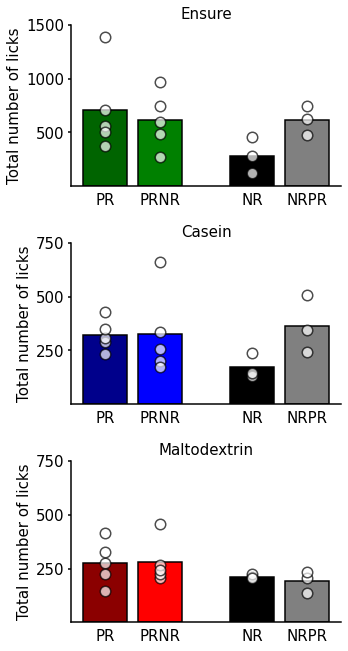

In [214]:
f,ax=plt.subplots(figsize=(5,10), ncols=1, nrows=3, sharey='row')
f.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.05, left=0.15)

colors_E=['Darkgreen','green','black', 'grey']
colors_C=['darkblue','blue','black', 'grey']
colors_M=['darkred','red','black', 'grey']
ax[0]= make_barscatter([[ensure_PR,ensure_PRNR],[ensure_NR,ensure_NRPR]], ax=ax[0], barfacecolor=colors_E)
ax[1]= make_barscatter([[cas_PR,cas_PRNR],[cas_NR,cas_NRPR]], ax=ax[1],barfacecolor= colors_C)
ax[2] = make_barscatter([[malt_PR,malt_PRNR],[malt_NR,malt_NRPR]], ax=ax[2],barfacecolor= colors_M)



ax[0].set_ylabel('Total number of licks',fontsize = 15)
ax[0].set_yticks([500,1000,1500])
ax[0].set_yticklabels([500,1000,1500], fontsize = 15)

ax[1].set_ylabel('Total number of licks',fontsize = 15)
ax[1].set_yticks([250,500,750])
ax[1].set_yticklabels([250,500,750], fontsize = 15)

ax[2].set_ylabel('Total number of licks',fontsize = 15)
ax[2].set_yticks([250,500,750])
ax[2].set_yticklabels([250,500,750], fontsize = 15)

ax[0].set_title('Ensure', fontsize =15)
ax[1].set_title('Casein', fontsize =15)
ax[2].set_title('Maltodextrin', fontsize =15)


f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\total_licks.png')

proteinpaired 

In [215]:
ppaired_NR=[]
ppaired_PR=[]

ppaired_NRPR=[]
ppaired_PRNR=[]


for mouse in mice: 
    temp_NR=[]
    temp_PR=[]
    
    temp_NRPR=[]
    temp_PRNR=[]
    
    for key in all_data.keys():
        d=all_data[key]
        if d['mouse']==mouse and d['solution']=='ppaired'and d['diet']== 'PR':
            temp_PR.append(d['total licks'])
        elif d['mouse']==mouse and d['solution']=='ppaired' and d['diet']== 'NR':
            temp_NR.append(d['total licks'])
        elif d['mouse']==mouse and d['solution']=='ppaired' and d['diet']== 'PRNR':
            temp_PRNR.append(d['total licks'])
        elif d['mouse']==mouse and d['solution']=='ppaired' and d['diet']== 'NRPR':
            temp_NRPR.append(d['total licks'])

                
    if len(temp_PR)> 0:
        ppaired_PR.append(np.mean(temp_PR))
    if len(temp_NR)>0:
        ppaired_NR.append(np.mean(temp_NR))
    if len(temp_PRNR)>0:
        ppaired_PRNR.append(np.mean(temp_PRNR))
    if len(temp_NRPR)>0:
        ppaired_NRPR.append(np.mean(temp_NRPR))
        
print('PR', ppaired_PR)
print('PRNR', ppaired_PRNR)
print('  ')
print('NR', ppaired_NR)
print('NRPR', ppaired_NRPR)

PR [385.0, 126.0, 477.0, 412.0, 277.0]
PRNR [355.0, 155.0, 294.0, 320.0]
  
NR [261.0, 195.0, 109.0]
NRPR [269.0, 241.0, 180.0]


In [216]:
mpaierd_NR=[]
mpaierd_PR=[]

mpaierd_NRPR=[]
mpaierd_PRNR=[]


for mouse in mice: 
    temp_NR=[]
    temp_PR=[]
    
    temp_NRPR=[]
    temp_PRNR=[]
    
    for key in all_data.keys():
        d=all_data[key]
        if d['mouse']==mouse and d['solution']=='mpaired'and d['diet']== 'PR':
            temp_PR.append(d['total licks'])
        elif d['mouse']==mouse and d['solution']=='mpaired' and d['diet']== 'NR':
            temp_NR.append(d['total licks'])
        elif d['mouse']==mouse and d['solution']=='mpaired' and d['diet']== 'PRNR':
            temp_PRNR.append(d['total licks'])
        elif d['mouse']==mouse and d['solution']=='mpaired' and d['diet']== 'NRPR':
            temp_NRPR.append(d['total licks'])

                
    if len(temp_PR)> 0:
        mpaierd_PR.append(np.mean(temp_PR))
    if len(temp_NR)>0:
        mpaierd_NR.append(np.mean(temp_NR))
    if len(temp_PRNR)>0:
        mpaierd_PRNR.append(np.mean(temp_PRNR))
    if len(temp_NRPR)>0:
        mpaierd_NRPR.append(np.mean(temp_NRPR))
        
print('PR', mpaierd_PR)
print('PRNR', mpaierd_PRNR)
print('  ')
print('NR', mpaierd_NR)
print('NRPR', mpaierd_NRPR)

PR [243.0, 174.0, 177.0, 373.0, 406.0]
PRNR [321.0, 31.0, 263.0, 346.0, 416.0]
  
NR [355.0, 195.0, 210.0]
NRPR [304.0, 171.0, 147.0]


In [217]:
# f,ax=plt.subplots(figsize=(5,10), ncols=1, nrows=4)
# f.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.05, left=0.15)


# colors_C=['darkblue','blue','black', 'grey']
# colors_PP=['skyblue','steelblue','darkgrey','lightgrey']
# colors_M=['darkred','red','black', 'grey']
# colors_CP=['lightcoral','indianred','darkgrey','lightgrey']

# ax[0]= make_barscatter([[cas_PR,cas_PRNR],[cas_NR,cas_NRPR]], ax=ax[0],barfacecolor= colors_C)
# ax[1]= make_barscatter([[ppaired_PR,ppaired_PRNR],[ppaired_NR,ppaired_NRPR]], ax=ax[1],barfacecolor= colors_PP)
# ax[2] = make_barscatter([[malt_PR,malt_PRNR],[malt_NR,malt_NRPR]], ax=ax[2],barfacecolor= colors_M)
# ax[3] = make_barscatter([[mpaierd_PR,mpaierd_PRNR],[mpaierd_NR,mpaierd_NRPR]], ax=ax[3],barfacecolor= colors_CP)


# ax[0].set_ylabel('# of licks',fontsize = 15)
# ax[0].set_yticks([250,500,750])
# ax[0].set_yticklabels([250,500,750], fontsize = 15)

# ax[1].set_ylabel('# of licks',fontsize = 15)
# ax[1].set_yticks([250,500,750])
# ax[1].set_yticklabels([250,500,750], fontsize = 15)

# ax[2].set_ylabel('# of licks',fontsize = 15)
# ax[2].set_yticks([250,500,750])
# ax[2].set_yticklabels([250,500,750], fontsize = 15)

# ax[3].set_ylabel('# of licks',fontsize = 15)
# ax[3].set_yticks([250,500,750])
# ax[3].set_yticklabels([250,500,750], fontsize = 15)

# ax[0].set_title('Protein', fontsize =15)
# ax[1].set_title('Protein paired', fontsize =15)
# ax[2].set_title('Carb', fontsize =15)
# ax[3].set_title('Carb paired', fontsize =15)

# f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\total_licks_koolaid.png')



## Licks per trial (all)

In [218]:
ensure_PR,ensure_PRNR,ensure_NR,ensure_NRPR= get_grouped_data(all_data, 'Ensure', 'licks per trial')
cas_PR,cas_PRNR,cas_NR,cas_NRPR= get_grouped_data(all_data, 'Cas', 'licks per trial')
malt_PR,malt_PRNR,malt_NR,malt_NRPR= get_grouped_data(all_data, 'Malt.', 'licks per trial')

Ensure

Casein

In [219]:
print('PR',cas_PR)
print('PRNR', cas_PRNR)
print('  ')
print('NR',cas_NR)
print('NRPR', cas_NRPR)

PR [2.7364522417153996, 2.3086303939962476, 2.900877192982456, 4.231435231435231, 4.978778883183568]
PRNR [7.753508771929824, 2.4960156802262063, 3.625779625779626, 5.280555555555555, 1.7402027027027027]
  
NR [1.200404858299595, 1.2601779317604616, 2.537626116573485]
NRPR [3.005430242272347, 5.448717948717949, 7.268537768537769]


Maltodextrin

In [220]:
print('PR', malt_PR)
print('PRNR', malt_PRNR)
print('  ')
print('NR', malt_NR)
print('NRPR', malt_NRPR)

PR [3.5341130604288495, 1.5707317073170735, 2.482905982905983, 3.9434542422347296, 2.9451754385964914]
PRNR [4.4558060084375875, 2.1532677848467325, 1.5964714714714714, 2.569337979094077, 2.8080745341614906]
  
NR [1.5737080103359176, 2.361788617886179, 2.230958230958231]
NRPR [1.896049896049896, 1.7040791187132651, 1.04800853485064]


## Figures licks per trial

Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.


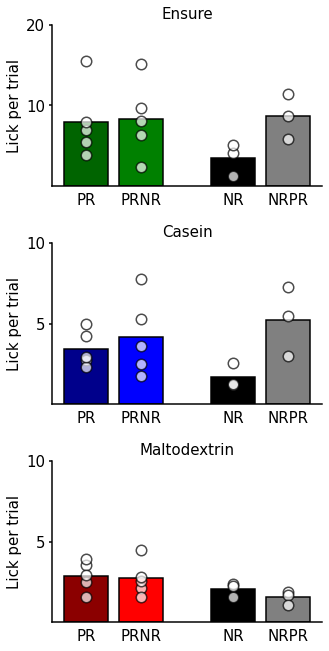

In [221]:
f,ax=plt.subplots(figsize=(5,10), ncols=1, nrows=3, sharey='row')
f.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.05, left=0.15)

colors_E=['Darkgreen','green','black', 'grey']
colors_C=['darkblue','blue','black', 'grey']
colors_M=['darkred','red','black', 'grey']
ax[0]= make_barscatter([[ensure_PR,ensure_PRNR],[ensure_NR,ensure_NRPR]], ax=ax[0], barfacecolor=colors_E)
ax[1]= make_barscatter([[cas_PR,cas_PRNR],[cas_NR,cas_NRPR]], ax=ax[1],barfacecolor= colors_C)
ax[2] = make_barscatter([[malt_PR,malt_PRNR],[malt_NR,malt_NRPR]], ax=ax[2],barfacecolor= colors_M)



ax[0].set_ylabel('Lick per trial',fontsize = 15)
ax[0].set_yticks([10,20])
ax[0].set_yticklabels([10,20], fontsize = 15)

ax[1].set_ylabel('Lick per trial',fontsize = 15)
ax[1].set_yticks([5,10])
ax[1].set_yticklabels([5,10], fontsize = 15)

ax[2].set_ylabel('Lick per trial',fontsize = 15)
ax[2].set_yticks([5,10])
ax[2].set_yticklabels([5,10], fontsize = 15)

ax[0].set_title('Ensure', fontsize =15)
ax[1].set_title('Casein', fontsize =15)
ax[2].set_title('Maltodextrin', fontsize =15)


f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\licks_per_trial2.png')

## Number of hit trials

In [222]:
ensure_PR,ensure_PRNR,ensure_NR,ensure_NRPR= get_grouped_data(all_data, 'Ensure', 'hit trial')
cas_PR,cas_PRNR,cas_NR,cas_NRPR= get_grouped_data(all_data, 'Cas', 'hit trial')
malt_PR,malt_PRNR,malt_NR,malt_NRPR= get_grouped_data(all_data, 'Malt.', 'hit trial')

Ensure

In [223]:
print('PR',ensure_PR)
print('PRNR', ensure_PRNR)
print('  ')
print('NR',ensure_NR)
print('NRPR', ensure_NRPR)

PR [26.333333333333332, 21.0, 24.0, 40.333333333333336, 35.0]
PRNR [39.333333333333336, 7.666666666666667, 29.0, 28.333333333333332, 35.0]
  
NR [12.333333333333334, 22.333333333333332, 27.333333333333332]
NRPR [31.0, 35.333333333333336, 36.0]


Casein

In [224]:
print('PR',cas_PR)
print('PRNR', cas_PRNR)
print('  ')
print('NR',cas_NR)
print('NRPR', cas_NRPR)

PR [17.666666666666668, 12.666666666666666, 15.333333333333334, 21.333333333333332, 22.0]
PRNR [38.666666666666664, 9.666666666666666, 24.0, 10.5, 17.0]
  
NR [11.333333333333334, 12.333333333333334, 17.333333333333332]
NRPR [17.0, 29.666666666666668, 29.0]


Maltodextrin

In [225]:
print('PR', malt_PR)
print('PRNR', malt_PRNR)
print('  ')
print('NR', malt_NR)
print('NRPR', malt_NRPR)

PR [18.666666666666668, 12.666666666666666, 14.0, 23.333333333333332, 14.333333333333334]
PRNR [27.333333333333332, 19.0, 13.5, 19.5, 16.5]
  
NR [18.666666666666668, 17.0, 13.333333333333334]
NRPR [16.0, 21.0, 11.5]


## Figures licks per trial

Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.


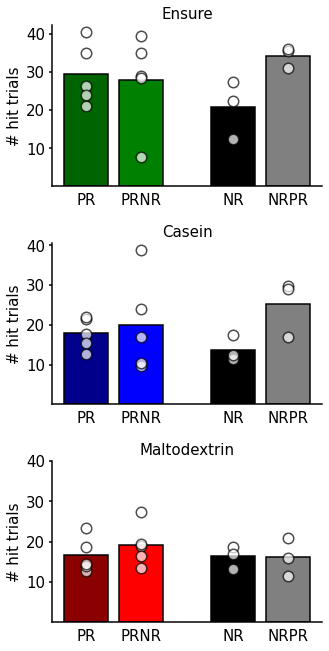

In [226]:
f,ax=plt.subplots(figsize=(5,10), ncols=1, nrows=3, sharey='row')
f.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.05, left=0.15)

colors_E=['Darkgreen','green','black', 'grey']
colors_C=['darkblue','blue','black', 'grey']
colors_M=['darkred','red','black', 'grey']
ax[0]= make_barscatter([[ensure_PR,ensure_PRNR],[ensure_NR,ensure_NRPR]], ax=ax[0], barfacecolor=colors_E)
ax[1]= make_barscatter([[cas_PR,cas_PRNR],[cas_NR,cas_NRPR]], ax=ax[1],barfacecolor= colors_C)
ax[2] = make_barscatter([[malt_PR,malt_PRNR],[malt_NR,malt_NRPR]], ax=ax[2],barfacecolor= colors_M)



ax[0].set_ylabel('# hit trials',fontsize = 15)
ax[0].set_yticks([10,20,30,40])
ax[0].set_yticklabels([10,20,30,40], fontsize = 15)

ax[1].set_ylabel('# hit trials',fontsize = 15)
ax[1].set_yticks([10,20,30,40])
ax[1].set_yticklabels([10,20,30,40], fontsize = 15)

ax[2].set_ylabel('# hit trials',fontsize = 15)
ax[2].set_yticks([10,20,30,40])
ax[2].set_yticklabels([10,20,30,40], fontsize = 15)

ax[0].set_title('Ensure', fontsize =15)
ax[1].set_title('Casein', fontsize =15)
ax[2].set_title('Maltodextrin', fontsize =15)


f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\hit_trial2.png')

## Latency to first lick

In [227]:
ensure_PR,ensure_PRNR,ensure_NR,ensure_NRPR= get_grouped_data(all_data, 'Ensure', 'latency')
cas_PR,cas_PRNR,cas_NR,cas_NRPR= get_grouped_data(all_data, 'Cas', 'latency')
malt_PR,malt_PRNR,malt_NR,malt_NRPR= get_grouped_data(all_data, 'Malt.', 'latency')

## Figures Latency

Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.


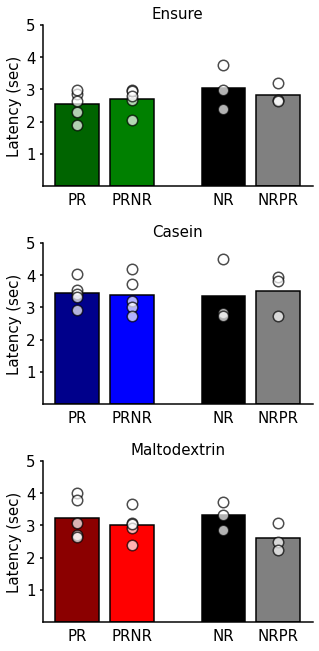

In [228]:
f,ax=plt.subplots(figsize=(5,10), ncols=1, nrows=3, sharey='row')
f.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.05, left=0.15)

colors_E=['Darkgreen','green','black', 'grey']
colors_C=['darkblue','blue','black', 'grey']
colors_M=['darkred','red','black', 'grey']
ax[0]= make_barscatter([[ensure_PR,ensure_PRNR],[ensure_NR,ensure_NRPR]], ax=ax[0], barfacecolor=colors_E)
ax[1]= make_barscatter([[cas_PR,cas_PRNR],[cas_NR,cas_NRPR]], ax=ax[1],barfacecolor= colors_C)
ax[2] = make_barscatter([[malt_PR,malt_PRNR],[malt_NR,malt_NRPR]], ax=ax[2],barfacecolor= colors_M)



ax[0].set_ylabel('Latency (sec)',fontsize = 15)
ax[0].set_yticks([10,20,30,40,50])
ax[0].set_yticklabels([1,2,3,4,5], fontsize = 15)

ax[1].set_ylabel('Latency (sec)',fontsize = 15)
ax[1].set_yticks([10,20,30,40,50])
ax[1].set_yticklabels([1,2,3,4,5], fontsize = 15)

ax[2].set_ylabel('Latency (sec)',fontsize = 15)
ax[2].set_yticks([10,20,30,40,50])
ax[2].set_yticklabels([1,2,3,4,5], fontsize = 15)

ax[0].set_title('Ensure', fontsize =15)
ax[1].set_title('Casein', fontsize =15)
ax[2].set_title('Maltodextrin', fontsize =15)


f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\latency.png')

## latency session

In [229]:
def get_grouped_latencybin(diet,solution, session):

    bin1=[]
    bin2=[]
    bin3=[]
    bin4=[]

    for key in all_data.keys():
        d=all_data[key]
        if d['solution']== solution and d['diet'] == diet and d['session'] == session: 
            if d['latency1'] > 0:
                bin1.append(d['latency1'])
            if d['latency2'] > 0:
                bin2.append(d['latency2'])
            if d['latency3'] > 0:
                bin3.append(d['latency3'])
            if d['latency4'] > 0:
                bin4.append(d['latency4'])
        


    b1_m=np.mean(bin1)
    b1_E=np.std(bin1, ddof=1) / np.sqrt(np.size(bin1))
    b2_m=np.mean(bin2)
    b2_E=np.std(bin2, ddof=1) / np.sqrt(np.size(bin2))
    b3_m=np.mean(bin3)
    b3_E=np.std(bin3, ddof=1) / np.sqrt(np.size(bin3))
    b4_m=np.mean(bin4)
    b4_E=np.std(bin4, ddof=1) / np.sqrt(np.size(bin4))
    
    mean=[b1_m,b2_m,b3_m,b4_m]
    error=[b1_E,b2_E,b3_E,b4_E]
    
    
    return mean,error
    

In [234]:
# Casein PR 
Cas_PR_S1_m, Cas_PR_S1_E= get_grouped_latencybin('PR','Cas','S1')
Cas_PR_S2_m, Cas_PR_S2_E= get_grouped_latencybin('PR','Cas','S2')
Cas_PR_S3_m, Cas_PR_S3_E= get_grouped_latencybin('PR','Cas','S3')

# maltodextrin PR 
malt_PR_S1_m, malt_PR_S1_E= get_grouped_latencybin('PR','Malt.','S1')
malt_PR_S2_m, malt_PR_S2_E= get_grouped_latencybin('PR','Malt.','S2')
malt_PR_S3_m, malt_PR_S3_E= get_grouped_latencybin('PR','Malt.','S3')

# Casein PRNR 
Cas_PRNR_S1_m, Cas_PRNR_S1_E= get_grouped_latencybin('PRNR','Cas','S1')
Cas_PRNR_S2_m, Cas_PRNR_S2_E= get_grouped_latencybin('PRNR','Cas','S2')
Cas_PRNR_S3_m, Cas_PRNR_S3_E= get_grouped_latencybin('PRNR','Cas','S3')

# maltodextrin PRNR 
malt_PRNR_S1_m, malt_PRNR_S1_E= get_grouped_latencybin('PRNR','Malt.','S1')
malt_PRNR_S2_m, malt_PRNR_S2_E= get_grouped_latencybin('PRNR','Malt.','S2')
malt_PRNR_S3_m, malt_PRNR_S3_E= get_grouped_latencybin('PRNR','Malt.','S3')

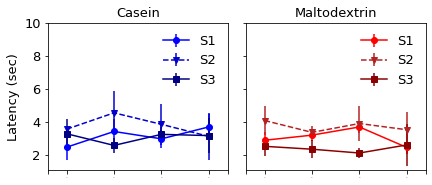

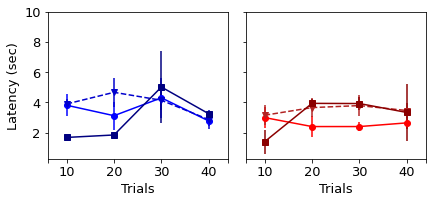

In [235]:
f1, [ax1,ax2] = plt.subplots(figsize=[7,3],ncols=2, gridspec_kw={'wspace':0.1,'width_ratios':[10,10]}, sharey=True)
f1.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.2, left=0.15)
x=[1,2,3,4]


ax1.errorbar(x, Cas_PR_S1_m, yerr=Cas_PR_S1_E, fmt="-o", color='blue')
ax1.errorbar(x, Cas_PR_S2_m, yerr=Cas_PR_S2_E, fmt="--v", color='mediumblue')
ax1.errorbar(x, Cas_PR_S3_m, yerr=Cas_PR_S3_E, fmt="-s", color='navy')


ax2.errorbar(x, malt_PR_S1_m, yerr=malt_PR_S1_E, fmt="-o", color='red')
ax2.errorbar(x, malt_PR_S2_m, yerr=malt_PR_S2_E, fmt="--v", color='firebrick')
ax2.errorbar(x, malt_PR_S3_m, yerr=malt_PR_S3_E, fmt="-s", color='darkred')

ax1.set_title('Casein',fontsize=13)
ax2.set_title('Maltodextrin',fontsize=13)

ax1.set_ylabel('Latency (sec)',fontsize = 13)



ax1.set_yticks([20,40,60,80,100])
ax2.set_yticks([20,40,60,80,100])
ax1.set_yticklabels([2,4,6,8,10],fontsize=13)
ax1.set_xticks([0.6,1,2,3,4,4.4])
ax2.set_xticks([0.6,1,2,3,4,4.4])
ax1.set_xticklabels([' ','10','20','30','40', ''], fontsize=0)
ax2.set_xticklabels([' ','10','20','30','40', ''], fontsize=0)

ax1.legend(['S1','S2','S3'], fontsize=13,frameon = False)
ax2.legend(['S1','S2','S3'], fontsize=13,frameon = False)





f2, [ax1,ax2] = plt.subplots(figsize=[7,3],ncols=2, gridspec_kw={'wspace':0.1,'width_ratios':[10,10]}, sharey=True)
f2.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.2,left=0.15)
x=[1,2,3,4]


ax1.errorbar(x, Cas_PRNR_S1_m, yerr=Cas_PRNR_S1_E, fmt="-o", color='blue')
ax1.errorbar(x, Cas_PRNR_S2_m, yerr=Cas_PRNR_S2_E, fmt="--v", color='mediumblue')
ax1.errorbar(x, Cas_PRNR_S3_m, yerr=Cas_PRNR_S3_E, fmt="-s", color='navy')


ax2.errorbar(x, malt_PRNR_S1_m, yerr=malt_PRNR_S1_E, fmt="-o", color='red')
ax2.errorbar(x, malt_PRNR_S2_m, yerr=malt_PRNR_S2_E, fmt="--v", color='firebrick')
ax2.errorbar(x, malt_PRNR_S3_m, yerr=malt_PRNR_S3_E, fmt="-s", color='darkred')



ax1.set_ylabel('Latency (sec)',fontsize = 13)

ax1.set_xlabel('Trials', fontsize = 13)
ax2.set_xlabel('Trials', fontsize = 13)

ax1.set_yticks([20,40,60,80,100])
ax2.set_yticks([20,40,60,80,100])
ax1.set_yticklabels([2,4,6,8,10],fontsize=13)
ax1.set_xticks([0.6,1,2,3,4,4.4])
ax2.set_xticks([0.6,1,2,3,4,4.4])
ax1.set_xticklabels([' ','10','20','30','40', ''], fontsize=13)
ax2.set_xticklabels([' ','10','20','30','40', ''], fontsize=13)


f1.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\LatencyPR.png')
f2.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\latencyPRNR.png')

In [236]:
# Casein NR 
Cas_NR_S1_m, Cas_NR_S1_E= get_grouped_latencybin('NR','Cas','S1')
Cas_NR_S2_m, Cas_NR_S2_E= get_grouped_latencybin('NR','Cas','S2')
Cas_NR_S3_m, Cas_NR_S3_E= get_grouped_latencybin('NR','Cas','S3')

# maltodextrin NR 
malt_NR_S1_m, malt_NR_S1_E= get_grouped_latencybin('NR','Malt.','S1')
malt_NR_S2_m, malt_NR_S2_E= get_grouped_latencybin('NR','Malt.','S2')
malt_NR_S3_m, malt_NR_S3_E= get_grouped_latencybin('NR','Malt.','S3')

# Casein NRPR
Cas_NRPR_S1_m, Cas_NRPR_S1_E= get_grouped_latencybin('NRPR','Cas','S1')
Cas_NRPR_S2_m, Cas_NRPR_S2_E= get_grouped_latencybin('NRPR','Cas','S2')
Cas_NRPR_S3_m, Cas_NRPR_S3_E= get_grouped_latencybin('NRPR','Cas','S3')

# maltodextrin NRPR 
malt_NRPR_S1_m, malt_NRPR_S1_E= get_grouped_latencybin('NRPR','Malt.','S1')
malt_NRPR_S2_m, malt_NRPR_S2_E= get_grouped_latencybin('NRPR','Malt.','S2')
malt_NRPR_S3_m, malt_NRPR_S3_E= get_grouped_latencybin('NRPR','Malt.','S3')

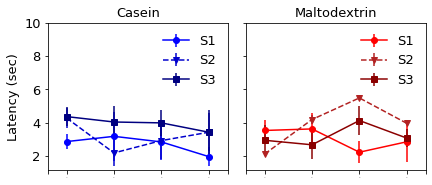

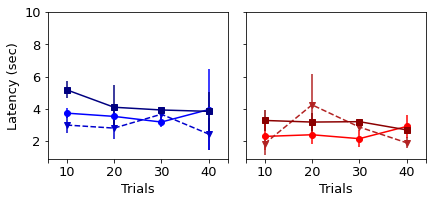

In [237]:
f1, [ax1,ax2] = plt.subplots(figsize=[7,3],ncols=2, gridspec_kw={'wspace':0.1,'width_ratios':[10,10]}, sharey=True)
f1.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.2,left=0.15)
x=[1,2,3,4]


ax1.errorbar(x, Cas_NR_S1_m, yerr=Cas_NR_S1_E, fmt="-o", color='blue')
ax1.errorbar(x, Cas_NR_S2_m, yerr=Cas_NR_S2_E, fmt="--v", color='mediumblue')
ax1.errorbar(x, Cas_NR_S3_m, yerr=Cas_NR_S3_E, fmt="-s", color='navy')


ax2.errorbar(x, malt_NR_S1_m, yerr=malt_NR_S1_E, fmt="-o", color='red')
ax2.errorbar(x, malt_NR_S2_m, yerr=malt_NR_S2_E, fmt="--v", color='firebrick')
ax2.errorbar(x, malt_NR_S3_m, yerr=malt_NR_S3_E, fmt="-s", color='darkred')

ax1.set_title('Casein',fontsize=13)
ax2.set_title('Maltodextrin',fontsize=13)

ax1.set_ylabel('Latency (sec)',fontsize = 13)

# ax1.set_xlabel('Time (min)', fontsize = 13)
# ax2.set_xlabel('Time (min)', fontsize = 13)

ax1.set_yticks([20,40,60,80,100])
ax2.set_yticks([20,40,60,80,100])
ax1.set_yticklabels([2,4,6,8,10],fontsize=13)
ax1.set_xticks([0.6,1,2,3,4,4.4])
ax2.set_xticks([0.6,1,2,3,4,4.4])
ax1.set_xticklabels([' ','10','20','30','40', ''], fontsize=0)
ax2.set_xticklabels([' ','10','20','30','40', ''], fontsize=0)

ax1.legend(['S1','S2','S3'], fontsize=13,frameon = False)
ax2.legend(['S1','S2','S3'], fontsize=13,frameon = False)





f2, [ax1,ax2] = plt.subplots(figsize=[7,3],ncols=2, gridspec_kw={'wspace':0.1,'width_ratios':[10,10]}, sharey=True)
f2.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.2,left=0.15)
x=[1,2,3,4]


ax1.errorbar(x, Cas_NRPR_S1_m, yerr=Cas_NRPR_S1_E, fmt="-o", color='blue')
ax1.errorbar(x, Cas_NRPR_S2_m, yerr=Cas_NRPR_S2_E, fmt="--v", color='mediumblue')
ax1.errorbar(x, Cas_NRPR_S3_m, yerr=Cas_NRPR_S3_E, fmt="-s", color='navy')


ax2.errorbar(x, malt_NRPR_S1_m, yerr=malt_NRPR_S1_E, fmt="-o", color='red')
ax2.errorbar(x, malt_NRPR_S2_m, yerr=malt_NRPR_S2_E, fmt="--v", color='firebrick')
ax2.errorbar(x, malt_NRPR_S3_m, yerr=malt_NRPR_S3_E, fmt="-s", color='darkred')



ax1.set_ylabel('Latency (sec)',fontsize = 13)

ax1.set_xlabel('Trials', fontsize = 13)
ax2.set_xlabel('Trials', fontsize = 13)

ax1.set_yticks([20,40,60,80,100])
ax2.set_yticks([20,40,60,80,100])
ax1.set_yticklabels([2,4,6,8,10],fontsize=13)
ax1.set_xticks([0.6,1,2,3,4,4.4])
ax2.set_xticks([0.6,1,2,3,4,4.4])
ax1.set_xticklabels([' ','10','20','30','40', ''], fontsize=13)
ax2.set_xticklabels([' ','10','20','30','40', ''], fontsize=13)

f1.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\LatencyNR.png')
f2.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\latencyNRPR.png')

In [238]:
cas_PR_S1,cas_PRNR_S1,cas_NR_S1,cas_NRPR_S1 = grouped_by_session(all_data, 'Cas','S1', 'latency')
cas_PR_S2,cas_PRNR_S2,cas_NR_S2,cas_NRPR_S2 = grouped_by_session(all_data, 'Cas','S2', 'latency')
cas_PR_S3,cas_PRNR_S3,cas_NR_S3,cas_NRPR_S3 = grouped_by_session(all_data, 'Cas','S3', 'latency')

malt_PR_S1,malt_PRNR_S1,malt_NR_S1,malt_NRPR_S1 = grouped_by_session(all_data, 'Malt.','S1', 'latency')
malt_PR_S2,malt_PRNR_S2,malt_NR_S2,malt_NRPR_S2 = grouped_by_session(all_data, 'Malt.','S2', 'latency')
malt_PR_S3,malt_PRNR_S3,malt_NR_S3,malt_NRPR_S3 = grouped_by_session(all_data, 'Malt.','S3', 'latency')


Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.


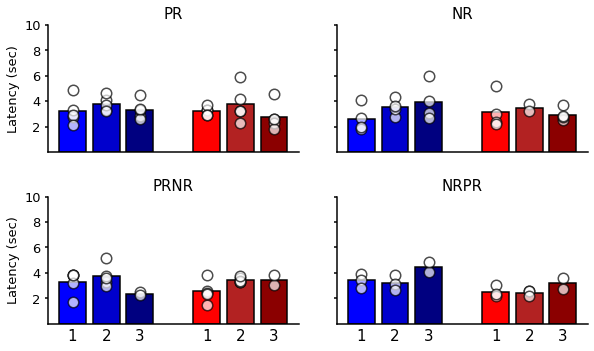

In [245]:
f,ax=plt.subplots(figsize=(10,5), ncols=2, nrows=2, sharey='row')
f.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.05, left=0.15)

colors_C=['blue','mediumblue','navy','red','firebrick','darkred']
# colors_M=['darkred','red','black', 'grey']
ax[0,0]= make_barscatter([[cas_PR_S1,cas_PR_S2,cas_PR_S3],[malt_PR_S1,malt_PR_S2,malt_PR_S3]], ax=ax[0,0], barfacecolor=colors_C)
ax[1,0]= make_barscatter([[cas_PRNR_S1,cas_PRNR_S2,cas_PRNR_S3],[malt_PRNR_S1,malt_PRNR_S2,malt_PRNR_S3]], ax=ax[1,0], barfacecolor=colors_C,barlabels=['1','2','3','1','2','3'])



ax[0,1]= make_barscatter([[cas_NR_S1,cas_NR_S2,cas_NR_S3],[malt_NR_S1,malt_NR_S2,malt_NR_S3]], ax=ax[0,1], barfacecolor=colors_C)
ax[1,1]= make_barscatter([[cas_NRPR_S1,cas_NRPR_S2,cas_NRPR_S3],[malt_NRPR_S1,malt_NRPR_S2,malt_NRPR_S3]], ax=ax[1,1], barfacecolor=colors_C,barlabels=['1','2','3','1','2','3'])



ax[0,0].set_ylabel('Latency (sec)',fontsize = 13)
ax[0,0].set_yticks([20,40,60,80,100])
ax[0,1].set_yticks([20,40,60,80,100])
ax[0,0].set_yticklabels([2,4,6,8,10],fontsize=13)



ax[1,0].set_ylabel('Latency (sec)',fontsize = 13)
ax[1,0].set_yticks([20,40,60,80,100])
ax[1,1].set_yticks([20,40,60,80,100])
ax[1,0].set_yticklabels([2,4,6,8,10],fontsize=13)

ax[0,0].set_title('PR',fontsize=15)
ax[0,1].set_title('NR',fontsize=15)
ax[1,0].set_title('PRNR',fontsize=15)
ax[1,1].set_title('NRPR',fontsize=15)




f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\latency_session.png')

# Total licks per trial

In [66]:
cas_PR_S1,cas_PRNR_S1,cas_NR_S1,cas_NRPR_S1 = grouped_by_session(all_data, 'Cas','S1', 'total licks')
cas_PR_S2,cas_PRNR_S2,cas_NR_S2,cas_NRPR_S2 = grouped_by_session(all_data, 'Cas','S2', 'total licks')
cas_PR_S3,cas_PRNR_S3,cas_NR_S3,cas_NRPR_S3 = grouped_by_session(all_data, 'Cas','S3', 'total licks')

malt_PR_S1,malt_PRNR_S1,malt_NR_S1,malt_NRPR_S1 = grouped_by_session(all_data, 'Malt.','S1', 'total licks')
malt_PR_S2,malt_PRNR_S2,malt_NR_S2,malt_NRPR_S2 = grouped_by_session(all_data, 'Malt.','S2', 'total licks')
malt_PR_S3,malt_PRNR_S3,malt_NR_S3,malt_NRPR_S3 = grouped_by_session(all_data, 'Malt.','S3', 'total licks')


In [67]:
# f,ax=plt.subplots(figsize=(10,5), ncols=2, nrows=2, sharey='row')
# f.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.05, left=0.15)

# colors_C=['blue','mediumblue','navy','red','firebrick','darkred']
# # colors_M=['darkred','red','black', 'grey']
# ax[0,0]= make_barscatter([[cas_PR_S1,cas_PR_S2,cas_PR_S3],[malt_PR_S1,malt_PR_S2,malt_PR_S3]], ax=ax[0,0], barfacecolor=colors_C)
# ax[1,0]= make_barscatter([[cas_PRNR_S1,cas_PRNR_S2,cas_PRNR_S3],[malt_PRNR_S1,malt_PRNR_S2,malt_PRNR_S3]], ax=ax[1,0], barfacecolor=colors_C,barlabels=['1','2','3','1','2','3'])



# ax[0,1]= make_barscatter([[cas_NR_S1,cas_NR_S2,cas_NR_S3],[malt_NR_S1,malt_NR_S2,malt_NR_S3]], ax=ax[0,1], barfacecolor=colors_C)
# ax[1,1]= make_barscatter([[cas_NRPR_S1,cas_NRPR_S2,cas_NRPR_S3],[malt_NRPR_S1,malt_NRPR_S2,malt_NRPR_S3]], ax=ax[1,1], barfacecolor=colors_C,barlabels=['1','2','3','1','2','3'])



# ax[0,0].set_ylabel('Number of licks',fontsize = 13)
# ax[0,0].set_yticks([250,500,750,1000])
# ax[0,1].set_yticks([250,500,750,1000])
# ax[0,0].set_yticklabels([250,500,750,1000], fontsize = 13)

# ax[1,0].set_ylabel('Number of licks',fontsize = 13)
# ax[1,0].set_yticks([250,500,750,1000])
# ax[1,1].set_yticks([250,500,750,1000])
# ax[1,0].set_yticklabels([250,500,750,1000], fontsize = 13)

# ax[0,0].set_title('PR',fontsize=18)
# ax[0,1].set_title('NR',fontsize=18)
# ax[1,0].set_title('PRNR',fontsize=18)
# ax[1,1].set_title('NRPR',fontsize=18)




# f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\total_licks_session.png')

## Cumulative licks Casein

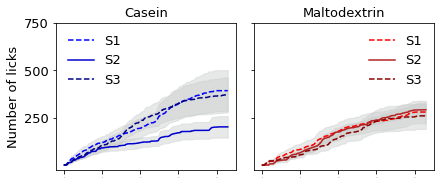

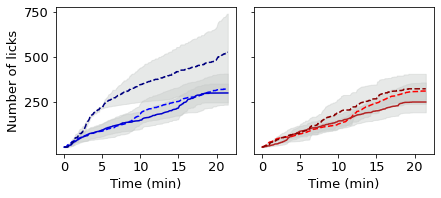

In [192]:
cas_PR_S1=[]
cas_PR_S2=[]
cas_PR_S3=[]

malt_PR_S1=[]
malt_PR_S2=[]
malt_PR_S3=[]

cas_PRNR_S1=[]
cas_PRNR_S2=[]
cas_PRNR_S3=[]

malt_PRNR_S1=[]
malt_PRNR_S2=[]
malt_PRNR_S3=[]
bins=[]


#     temp_NRPR=[]
#     temp_PRNR=[]
    
for key in all_data.keys():
    d=all_data[key]
    if d['solution']=='Cas'and d['diet']== 'PR' and d['session']=='S1':
        cas_PR_S1.append(d['cumulative licks'])
        bins=d['lick bins']
        
    elif d['solution']=='Cas'and d['diet']== 'PR' and d['session']=='S2':
        cas_PR_S2.append(d['cumulative licks'])
        
    elif d['solution']=='Cas'and d['diet']== 'PR' and d['session']=='S3':
        cas_PR_S3.append(d['cumulative licks'])
        
        
        
    elif d['solution']=='Cas'and d['diet']== 'PRNR' and d['session']=='S1':
        cas_PRNR_S1.append(d['cumulative licks'])
    elif d['solution']=='Cas'and d['diet']== 'PRNR' and d['session']=='S2':
        cas_PRNR_S2.append(d['cumulative licks'])
    elif d['solution']=='Cas'and d['diet']== 'PRNR' and d['session']=='S3':
        cas_PRNR_S3.append(d['cumulative licks'])
        
        
    elif d['solution']=='Malt.'and d['diet']== 'PR' and d['session']=='S1':
        malt_PR_S1.append(d['cumulative licks'])
    elif d['solution']=='Malt.'and d['diet']== 'PR' and d['session']=='S2':
        malt_PR_S2.append(d['cumulative licks'])
    elif d['solution']=='Malt.'and d['diet']== 'PR' and d['session']=='S3':
        malt_PR_S3.append(d['cumulative licks'])
        
    elif d['solution']=='Malt.'and d['diet']== 'PRNR' and d['session']=='S1':
        malt_PRNR_S1.append(d['cumulative licks'])
    elif d['solution']=='Malt.'and d['diet']== 'PRNR' and d['session']=='S2':
        malt_PRNR_S2.append(d['cumulative licks'])
    elif d['solution']=='Malt.'and d['diet']== 'PRNR' and d['session']=='S3':
        malt_PRNR_S3.append(d['cumulative licks'])

      
       
# Making figures

f1, [ax1,ax2] = plt.subplots(figsize=[7,3],ncols=2, gridspec_kw={'wspace':0.1,'width_ratios':[10,10]}, sharey=True)
f1.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.2,left=0.15)



     
tp.shadedError(ax1,cas_PR_S1, linecolor='blue', linestyle='--', linewidth=1.5)
tp.shadedError(ax1,cas_PR_S2, linecolor='mediumblue',linestyle='-', linewidth=1.5)
tp.shadedError(ax1,cas_PR_S3, linecolor='navy',linestyle='--', linewidth=1.5)

tp.shadedError(ax2,malt_PR_S1, linecolor='red', linestyle='--', linewidth=1.5)
tp.shadedError(ax2,malt_PR_S2, linecolor='firebrick',linestyle='-', linewidth=1.5)
tp.shadedError(ax2,malt_PR_S3, linecolor='darkred',linestyle='--', linewidth=1.5)

ax1.set_title('Casein',fontsize=13)
ax2.set_title('Maltodextrin',fontsize=13)

ax1.set_ylabel('Number of licks',fontsize = 13)

# ax1.set_xlabel('Time (min)', fontsize = 13)
# ax2.set_xlabel('Time (min)', fontsize = 13)

ax1.set_yticks([250,500,750])
ax2.set_yticks([250,500,750])
ax1.set_yticklabels([250,500,750],fontsize=13)
ax1.set_xticks([0,300, 600,900 ,1200])
ax2.set_xticks([0,300, 600,900 ,1200])
ax1.set_xticklabels([0,5,10,15,20], fontsize=0)
ax2.set_xticklabels([0,5,10,15,20], fontsize=0)

ax1.legend(['S1','S2','S3'], fontsize=13,frameon = False)
ax2.legend(['S1','S2','S3'], fontsize=13,frameon = False)


f2, [ax1,ax2]= plt.subplots(figsize=[7,3],ncols=2, gridspec_kw={'wspace':0.1,'width_ratios':[10,10]}, sharey=True)
f2.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.2,left=0.15)

tp.shadedError(ax1,cas_PRNR_S1, linecolor='blue', linestyle='--', linewidth=1.5)
tp.shadedError(ax1,cas_PRNR_S2, linecolor='mediumblue',linestyle='-', linewidth=1.5)
tp.shadedError(ax1,cas_PRNR_S3, linecolor='navy',linestyle='--', linewidth=1.5)



tp.shadedError(ax2,malt_PRNR_S1, linecolor='red', linestyle='--', linewidth=1.5)
tp.shadedError(ax2,malt_PRNR_S2, linecolor='firebrick',linestyle='-', linewidth=1.5)
tp.shadedError(ax2,malt_PRNR_S3, linecolor='darkred',linestyle='--', linewidth=1.5)

ax1.set_yticks([250,500,750])
ax2.set_yticks([250,500,750])
ax1.set_yticklabels([250,500,750],fontsize=13)
ax1.set_xticks([0,300, 600,900 ,1200])
ax2.set_xticks([0,300, 600,900 ,1200])
ax1.set_xticklabels([0,5,10,15,20], fontsize=13)
ax2.set_xticklabels([0,5,10,15,20], fontsize=13)

ax1.set_ylabel('Number of licks',fontsize = 13)

ax1.set_xlabel('Time (min)', fontsize = 13)
ax2.set_xlabel('Time (min)', fontsize = 13)


f1.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\cumPR.png')
f2.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\cumPRNR.png')

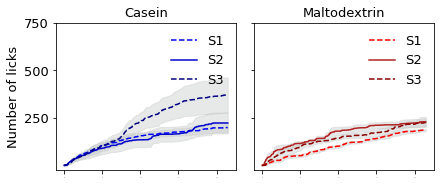

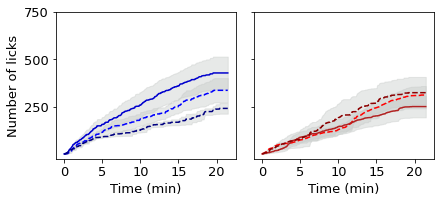

In [194]:
cas_NR_S1=[]
cas_NR_S2=[]
cas_NR_S3=[]

malt_NR_S1=[]
malt_NR_S2=[]
malt_NR_S3=[]

cas_NRPR_S1=[]
cas_NRPR_S2=[]
cas_NRPR_S3=[]

malt_NRPR_S1=[]
malt_NRPR_S2=[]
malt_NRPR_S3=[]
bins=[]


#     temp_NRPR=[]
#     temp_PRNR=[]
    
for key in all_data.keys():
    d=all_data[key]
    if d['solution']=='Cas'and d['diet']== 'NR' and d['session']=='S1':
        cas_NR_S1.append(d['cumulative licks'])
        bins=d['lick bins']
        
    elif d['solution']=='Cas'and d['diet']== 'NR' and d['session']=='S2':
        cas_NR_S2.append(d['cumulative licks'])
        
    elif d['solution']=='Cas'and d['diet']== 'NR' and d['session']=='S3':
        cas_NR_S3.append(d['cumulative licks'])
        
        
        
    elif d['solution']=='Cas'and d['diet']== 'NRPR' and d['session']=='S1':
        cas_NRPR_S1.append(d['cumulative licks'])
    elif d['solution']=='Cas'and d['diet']== 'NRPR' and d['session']=='S2':
        cas_NRPR_S2.append(d['cumulative licks'])
    elif d['solution']=='Cas'and d['diet']== 'NRPR' and d['session']=='S3':
        cas_NRPR_S3.append(d['cumulative licks'])
        
        
    elif d['solution']=='Malt.'and d['diet']== 'NR' and d['session']=='S1':
        malt_NR_S1.append(d['cumulative licks'])
    elif d['solution']=='Malt.'and d['diet']== 'NR' and d['session']=='S2':
        malt_NR_S2.append(d['cumulative licks'])
    elif d['solution']=='Malt.'and d['diet']== 'NR' and d['session']=='S3':
        malt_NR_S3.append(d['cumulative licks'])
        
    elif d['solution']=='Malt.'and d['diet']== 'PRNR' and d['session']=='S1':
        malt_NRPR_S1.append(d['cumulative licks'])
    elif d['solution']=='Malt.'and d['diet']== 'PRNR' and d['session']=='S2':
        malt_NRPR_S2.append(d['cumulative licks'])
    elif d['solution']=='Malt.'and d['diet']== 'PRNR' and d['session']=='S3':
        malt_NRPR_S3.append(d['cumulative licks'])

      
       
# Making figures

f1, [ax1,ax2] = plt.subplots(figsize=[7,3],ncols=2, gridspec_kw={'wspace':0.1,'width_ratios':[10,10]}, sharey=True)
f1.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.2,left=0.15)



     
tp.shadedError(ax1,cas_NR_S1, linecolor='blue', linestyle='--', linewidth=1.5)
tp.shadedError(ax1,cas_NR_S2, linecolor='mediumblue',linestyle='-', linewidth=1.5)
tp.shadedError(ax1,cas_PR_S3, linecolor='navy',linestyle='--', linewidth=1.5)


tp.shadedError(ax2,malt_NR_S1, linecolor='red', linestyle='--', linewidth=1.5)
tp.shadedError(ax2,malt_NR_S2, linecolor='firebrick',linestyle='-', linewidth=1.5)
tp.shadedError(ax2,malt_NR_S3, linecolor='darkred',linestyle='--', linewidth=1.5)

ax1.set_title('Casein',fontsize=13)
ax2.set_title('Maltodextrin',fontsize=13)

ax1.set_ylabel('Number of licks',fontsize = 13)
ax1.legend(['S1','S2','S3'], fontsize=13,frameon = False)
ax2.legend(['S1','S2','S3'], fontsize=13,frameon = False)

# ax1.set_xlabel('Time (min)', fontsize = 13)
# ax2.set_xlabel('Time (min)', fontsize = 13)

ax1.set_yticks([250,500,750])
ax2.set_yticks([250,500,750])
ax1.set_yticklabels([250,500,750],fontsize=13)
ax1.set_xticks([0,300, 600,900 ,1200])
ax2.set_xticks([0,300, 600,900 ,1200])
ax1.set_xticklabels([0,5,10,15,20], fontsize=0)
ax2.set_xticklabels([0,5,10,15,20], fontsize=0)

f2, [ax1,ax2]= plt.subplots(figsize=[7,3],ncols=2, gridspec_kw={'wspace':0.1,'width_ratios':[10,10]}, sharey=True)
f2.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.2,left=0.15)

tp.shadedError(ax1,cas_NRPR_S1, linecolor='blue', linestyle='--', linewidth=1.5)
tp.shadedError(ax1,cas_NRPR_S2, linecolor='mediumblue',linestyle='-', linewidth=1.5)
tp.shadedError(ax1,cas_NRPR_S3, linecolor='navy',linestyle='--', linewidth=1.5)



tp.shadedError(ax2,malt_NRPR_S1, linecolor='red', linestyle='--', linewidth=1.5)
tp.shadedError(ax2,malt_NRPR_S2, linecolor='firebrick',linestyle='-', linewidth=1.5)
tp.shadedError(ax2,malt_NRPR_S3, linecolor='darkred',linestyle='--', linewidth=1.5)

ax1.set_yticks([250,500,750])
ax2.set_yticks([250,500,750])
ax1.set_yticklabels([250,500,750],fontsize=13)
ax1.set_xticks([0,300, 600,900 ,1200])
ax2.set_xticks([0,300, 600,900 ,1200])
ax1.set_xticklabels([0,5,10,15,20], fontsize=13)
ax2.set_xticklabels([0,5,10,15,20], fontsize=13)

ax1.set_ylabel('Number of licks',fontsize = 13)

ax1.set_xlabel('Time (min)', fontsize = 13)
ax2.set_xlabel('Time (min)', fontsize = 13)


f1.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\cumNR.png')
f2.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\cumNRPR.png')